#### This notebook analyzes a stock symbol's historical data by and predicts the future stock price using 3 different machine learning regression algorithms

> DecisionTreeRegressor

> MLPRegressor

> Ridge



---









Stock price of the symbol is downloaded using yahoofinance library that is available in python using pip. For the purpose of this analysis, MSFT symbol is selected and the below code analysis the data we got from the library. Rolling mean and the returns per day are plotted for better understanding.

In [60]:
!pip install yahoofinance

In [0]:
import yahoofinance as yf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
symbol = 'MSFT'
historical = yf.HistoricalPrices(symbol, '2010-01-01', '2019-01-11')
dfs = historical.to_dfs()
df = dfs['Historical Prices']
df.index = pd.to_datetime(df.index)

In [63]:
print(df.tail())

                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2019-01-04   99.720001  102.510002  ...  100.786606  44060600
2019-01-07  101.639999  103.269997  ...  100.915146  35656100
2019-01-08  103.040001  103.970001  ...  101.646843  31514400
2019-01-09  103.860001  104.879997  ...  103.100357  32280800
2019-01-10  103.220001  103.750000  ...  102.437866  30067600

[5 rows x 6 columns]


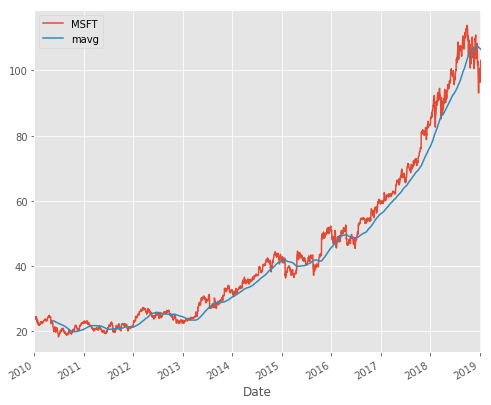

In [64]:

#Find the rolling mean of the stock
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label=symbol)
mavg.plot(label='mavg')
plt.legend()

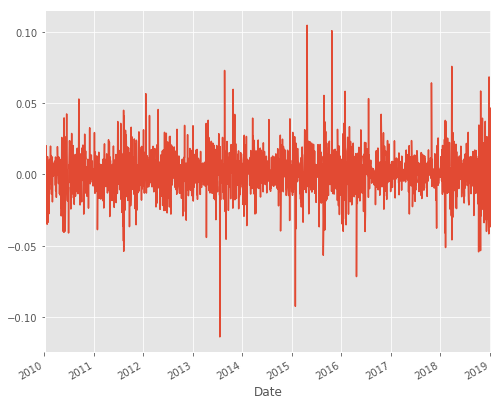

In [65]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [66]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
print(dfreg.head())
len(dfreg)

            Adj Close    Volume    HL_PCT  PCT_change
Date                                                 
2010-01-04  24.443624  38409100  1.647819    1.077727
2010-01-05  24.451517  49749600  1.485791    0.356561
2010-01-06  24.301458  58182400  1.819955   -0.356214
2010-01-07  24.048725  50559700  1.674877   -0.587653
2010-01-08  24.214581  51197400  2.087407    1.254950


2271

In [67]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
print(dfreg.head())
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
print(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

            Adj Close    Volume    HL_PCT  PCT_change      label
Date                                                            
2010-01-04  24.443624  38409100  1.647819    1.077727  22.129574
2010-01-05  24.451517  49749600  1.485791    0.356561  21.892639
2010-01-06  24.301458  58182400  1.819955   -0.356214  22.121681
2010-01-07  24.048725  50559700  1.674877   -0.587653  22.105875
2010-01-08  24.214581  51197400  2.087407    1.254950  22.208551
[[-0.78940849 -0.13677484 -0.11690621  0.90797123]
 [-0.78909361  0.34678356 -0.29190392  0.2796188 ]
 [-0.79507997  0.70635777  0.06900848 -0.34142256]
 ...
 [ 2.29048935 -0.43076453  0.47779712 -0.23399375]
 [ 2.34847495 -0.39808527 -0.19788845  0.31290034]
 [ 2.32204594 -0.49245602 -0.46837808  0.28971022]]


3 Regression algorithms are trained using 60% of the dataset and the remaining 40% is used to test the model. The confidence scores are printed for each model. Models are hypertuned to increase the score level. For example, DecisionTreeRegressor is analyzed with different max_depth values and took the best value out of the possible iterations. Similarly, for neural network, different hidden layers with different activation functions are analyzed. 

Plots are shown with forecast values that are predicted by each model. 

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


#DecisionTree Regression
clfdt = DecisionTreeRegressor(max_depth=5)
clfdt.fit(X_train, y_train)

#Neural Network
clfnn = MLPRegressor(hidden_layer_sizes=(20,), activation='logistic', solver='sgd',
                     learning_rate='adaptive', max_iter=1000, 
                     learning_rate_init=0.01, alpha=0.01)
clfnn.fit(X_train, y_train)


#Ridge Regression
clfr = Ridge(alpha=.5)
clfr.fit(X_train, y_train)

#let's evaluate all of the models against eachother
confidencedt = clfdt.score(X_test, y_test)
confidencenn = clfnn.score(X_test, y_test)
confidencer = clfr.score(X_test, y_test)

# results
print('The DT regression confidence is ', confidencedt)
print('The Neural network confidence is ', confidencenn)
print('The Ridge regression confidence is ', confidencer)

#printing some of the stocks forecasts
forecast_set_dt = clfdt.predict(X_lately) 
forecast_set_nn = clfnn.predict(X_lately) 
forecast_set_r = clfr.predict(X_lately)

dfreg['Forecast'] = np.nan
results_dt = dfreg.copy()
results_nn = dfreg.copy()
results_r = dfreg.copy()




The DT regression confidence is  0.9918180201026243
The Neural network confidence is  0.9907541474012871
The Ridge regression confidence is  0.989768909670379


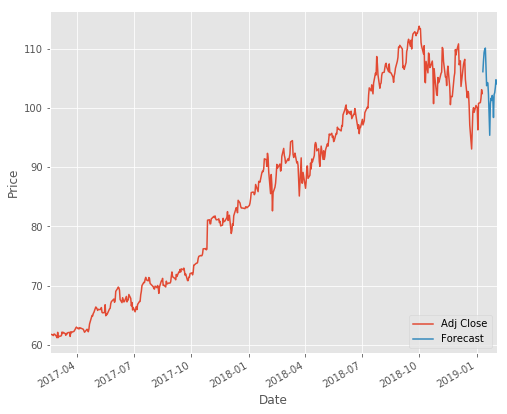

In [69]:
#results
import datetime
#Plotting the forecast with existing historical data so we can compare it to future price movements
last_date = results_reg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    results_dt.loc[next_date] = [np.nan for _ in range(len(results_dt.columns)-1)]+[i]

results_dt['Adj Close'].tail(500).plot()
results_dt['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

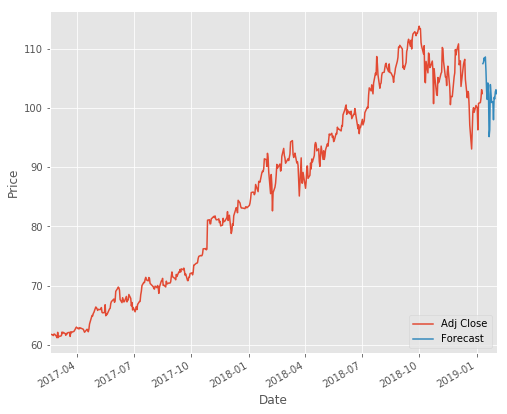

In [70]:
last_date = results_poly2.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_poly2: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    results_nn.loc[next_date] = [np.nan for _ in range(len(results_nn.columns)-1)]+[i]

results_nn['Adj Close'].tail(500).plot()
results_nn['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

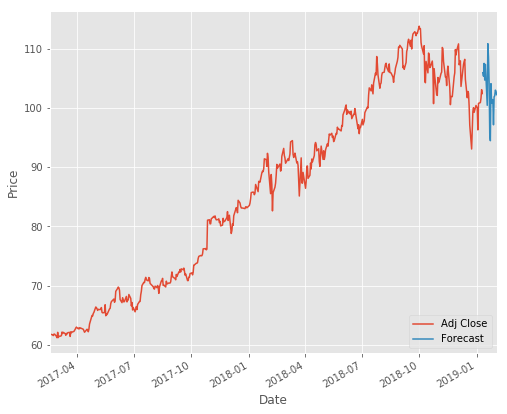

In [71]:
last_date = results_poly3.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_poly3: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    results_r.loc[next_date] = [np.nan for _ in range(len(results_r.columns)-1)]+[i]

results_r['Adj Close'].tail(500).plot()
results_r['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Conclusion: Based on the confidence level and the graphs, for the current analysis, DecisionTreeRegressor model is the best performing one. 